In [2]:
%run ../talktools.py

<div class="alert alert-info">sklearn is not built for deep/complex networks such as required in covnets (see below). We must go to specialized software (and potentially specialized hardware)</div>

# Deep Learning Frameworks

Almost all frameworks written in low-level C++/C with Python (or other scripting bindings)

### Low-level frameworks

   - Tensorflow (Google) Nov 2015
   - Theano
   - Caffe (Berkeley)
   - Torch (Lua)
   - pytorch (Python)
   - CNTK (Microsoft)
   - Chainer
   - PaddlePaddle (Baidu) Aug 2016
   
### High level frameworks (Python)

   - Keras (atop Tensorflow, Theano)
   - TFLearn 
   - nolearn
   - SkFlow (part of tensorflow)
   - [Lasagne](http://lasagne.readthedocs.io/en/latest/index.html) (atop Theano)
   
<img src="https://pbs.twimg.com/media/DX0lfBNU8AEs8KG.png:large" width="75%">
Source: https://twitter.com/fchollet/status/971863128341323776

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">TensorFlow is the platform of choice for deep learning in the research community. These are deep learning framework mentions on arXiv over the past 3 months <img src="https://pbs.twimg.com/media/DXy_uc0VAAAIhKG.jpg:small">

&mdash; François Chollet (@fchollet) <a href="https://twitter.com/fchollet/status/971863128341323776?ref_src=twsrc%5Etfw">March 8, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


see also: https://github.com/mbadry1/Top-Deep-Learning

In [3]:
# load the data from before
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
df = pd.read_csv("galspec.csv")
X = df[['dered_r', 'ug_color', 'gr_color', 'ri_color', 'iz_color', 'modelMagErr_u',
       'modelMagErr_g', 'modelMagErr_r', 'modelMagErr_i', 'modelMagErr_z',
       'fiberMag_r', 'fiber_ug', 'fiber_gr', 'fiber_ri', 'fiber_iz']]
y = df[["specz"]]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42, shuffle=True)

pt = preprocessing.PowerTransformer()  # this serves to rescale (non-linearly) the data so that it is roughly Gaussian
X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

In [4]:
# Import TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense, Activation

# Print TensorFlow version
print(tf.__version__)

/Users/jbloom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.9.0


Using TensorFlow backend.


See https://keras.io/getting-started/sequential-model-guide/

In [5]:
def nn_clf():
    model = Sequential()
    model.add(Dense(10, input_shape=(15,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(10,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(5,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="relu", kernel_initializer='random_uniform'))
    model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [6]:
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

clf = KerasRegressor(build_fn=nn_clf, batch_size=32, epochs=50)
clf.fit(X_train_scaled, y_train)

Epoch 1/50
3350/3350 [==============================] - 1s 275us/step - loss: 0.0854 - mean_absolute_error: 0.2466 - mean_squared_error: 0.0854
Epoch 2/50
3350/3350 [==============================] - 0s 64us/step - loss: 0.0060 - mean_absolute_error: 0.0582 - mean_squared_error: 0.0060
Epoch 3/50
3350/3350 [==============================] - 0s 66us/step - loss: 0.0039 - mean_absolute_error: 0.0458 - mean_squared_error: 0.0039
Epoch 4/50
3350/3350 [==============================] - 0s 64us/step - loss: 0.0032 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0032
Epoch 5/50
3350/3350 [==============================] - 0s 77us/step - loss: 0.0029 - mean_absolute_error: 0.0373 - mean_squared_error: 0.0029
Epoch 6/50
3350/3350 [==============================] - 0s 67us/step - loss: 0.0026 - mean_absolute_error: 0.0350 - mean_squared_error: 0.0026
Epoch 7/50
3350/3350 [==============================] - 0s 72us/step - loss: 0.0025 - mean_absolute_error: 0.0334 - mean_squared_error: 0.002

MSE 0.049605996592402724


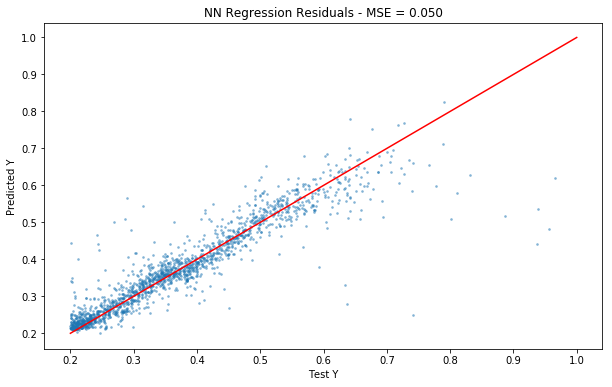

In [8]:
# how well did we do?
import numpy as np
from sklearn.metrics import mean_squared_error
mse = np.sqrt(mean_squared_error(y_test, clf.predict(X_test_scaled))) ; print("MSE",mse)

plt.figure(figsize=(10,6))
plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(y_test,clf.predict(X_test_scaled),alpha=0.4,s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.2,1],[0.2,1.0],c="r")

Maybe we also want to predict the error in the photometric redshift. So we can try to predict 2 outputs.

In [9]:
def nn_clf_two():
    model = Sequential()
    model.add(Dense(15, input_shape=(15,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(12,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(10,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(5,  activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(2, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [10]:
nn_clf_two().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                192       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 12        
Total params: 629
Trainable params: 629
Non-trainable params: 0
_________________________________________________________________


In [11]:
y = df[["specz", "speczerr"]]
y.head()

,specz,speczerr
0,0.250500,0.000046
1,0.268236,0.000052
2,0.355940,0.000091
3,0.235981,0.000063
4,0.212389,0.000032


The scales of the outputs are very different. Let's rescale them.

In [12]:
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42, shuffle=True)

pt = preprocessing.PowerTransformer()  
X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

pty = preprocessing.PowerTransformer()
pty.fit(y_train)
y_train_scaled = pty.transform(y_train)
y_test_scaled = pty.transform(y_test)

In [13]:
clf = KerasRegressor(build_fn=nn_clf_two, batch_size=64, epochs=100)
clf.fit(X_train_scaled, y_train_scaled)

Epoch 1/100
3350/3350 [==============================] - 1s 273us/step - loss: 0.9958 - mean_absolute_error: 0.8207 - mean_squared_error: 0.9958
Epoch 2/100
3350/3350 [==============================] - 0s 40us/step - loss: 0.7042 - mean_absolute_error: 0.6682 - mean_squared_error: 0.7042
Epoch 3/100
3350/3350 [==============================] - 0s 38us/step - loss: 0.2739 - mean_absolute_error: 0.3775 - mean_squared_error: 0.2739
Epoch 4/100
3350/3350 [==============================] - 0s 36us/step - loss: 0.2309 - mean_absolute_error: 0.3322 - mean_squared_error: 0.2309
Epoch 5/100
3350/3350 [==============================] - 0s 41us/step - loss: 0.2240 - mean_absolute_error: 0.3241 - mean_squared_error: 0.2240
Epoch 6/100
3350/3350 [==============================] - 0s 33us/step - loss: 0.2209 - mean_absolute_error: 0.3207 - mean_squared_error: 0.2209
Epoch 7/100
3350/3350 [==============================] - 0s 33us/step - loss: 0.2186 - mean_absolute_error: 0.3176 - mean_squared_error

3350/3350 [==============================] - 0s 38us/step - loss: 0.1962 - mean_absolute_error: 0.2952 - mean_squared_error: 0.1962
Epoch 58/100
3350/3350 [==============================] - 0s 33us/step - loss: 0.1963 - mean_absolute_error: 0.2951 - mean_squared_error: 0.1963
Epoch 59/100
3350/3350 [==============================] - 0s 35us/step - loss: 0.1961 - mean_absolute_error: 0.2955 - mean_squared_error: 0.1961
Epoch 60/100
3350/3350 [==============================] - 0s 39us/step - loss: 0.1960 - mean_absolute_error: 0.2960 - mean_squared_error: 0.1960
Epoch 61/100
3350/3350 [==============================] - 0s 37us/step - loss: 0.1959 - mean_absolute_error: 0.2957 - mean_squared_error: 0.1959
Epoch 62/100
3350/3350 [==============================] - 0s 35us/step - loss: 0.1955 - mean_absolute_error: 0.2945 - mean_squared_error: 0.1955
Epoch 63/100
3350/3350 [==============================] - 0s 39us/step - loss: 0.1966 - mean_absolute_error: 0.2961 - mean_squared_error: 0.196

In [14]:
clf.predict(X_test_scaled)

array([[-0.8118694 , -0.7371844 ],
       [-0.3598481 , -0.32668713],
       [-0.26914045, -0.24605995],
       ...,
       [ 0.36382547,  0.3307846 ],
       [-1.1180959 , -1.0127645 ],
       [-0.2144804 , -0.19680016]], dtype=float32)

(0, 0.0005133296)

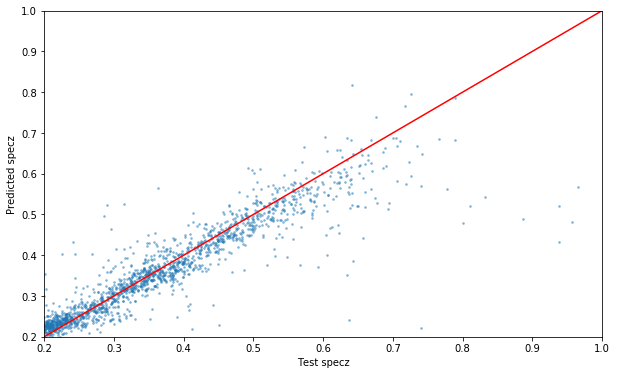

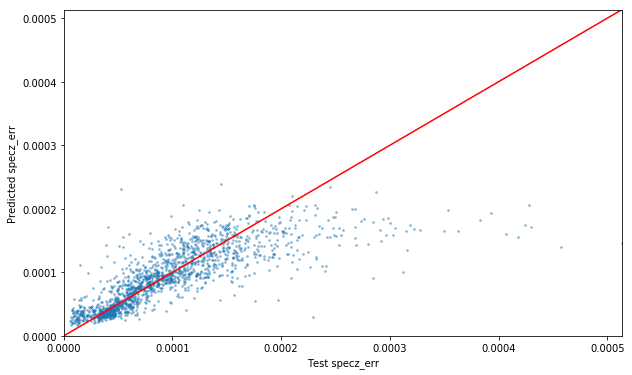

In [15]:
# how well did we do?
import numpy as np
from sklearn.metrics import mean_squared_error
#mse = np.sqrt(mean_squared_error(y_test, clf.predict(X_test_scaled))) ; print("MSE",mse)

predicted_y = pty.inverse_transform(clf.predict(X_test_scaled))

plt.figure(figsize=(10,6))
#plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(y_test[:,0], predicted_y[:,0],alpha=0.4,s=3)
plt.xlabel("Test specz")
plt.ylabel("Predicted specz")
plt.plot([-1,3],[-1,3],c="r")
plt.xlim(0.2,1)
plt.ylim(0.2,1)

plt.figure(figsize=(10,6))
#plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(y_test[:,1], predicted_y[:,1], alpha=0.4,s=3)
plt.xlabel("Test specz_err")
plt.ylabel("Predicted specz_err")
plt.plot([0,1],[0,1],c="r")
plt.xlim(0,y_test[:,1].max())
plt.ylim(0,y_test[:,1].max())

<img src="http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png">

Source: http://www.asimovinstitute.org/neural-network-zoo/

## Convolutional Neural Nets (ConvNets)

NNs built for images (or more generally, inputs with structure). **These may be useful for Lab #2**

### Key Ideas: 
  - layers see only parts of each image (effectively all other weights are zero).
  - some layers do simple operations on previous layers to reduce dimensionality (e.g., take the largest value in a a 3x3 range)
  - "Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters."
 
<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg">

"An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input - see discussion of depth columns in text below. "

cf. http://cs231n.github.io/convolutional-networks/

<img src="http://www.nature.com/nature/journal/v521/n7553/images/nature14539-f2.jpg">
Source: http://www.nature.com/nature/journal/v521/n7553/fig_tab/nature14539_F2.html

### Pooling

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="40%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="40%">
Source: http://cs231n.github.io/convolutional-networks/

We can think of understanding spectra and timeseries data in the context of convolutions.

629


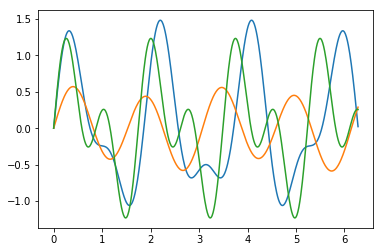

In [18]:
# here's a way to generate some 1D sources with some structure
# set by just a few parameters
def gen_timeseries(ts, period, harmonic_phase_amplitudes):
    lightcurve = np.zeros(ts.shape)
    for i, (amp, phase) in enumerate(harmonic_phase_amplitudes):
        lightcurve += amp*np.sin(  ((i+1)*period + phase)*ts)
    return lightcurve

ts = np.arange(0, 2*np.pi, 0.01)
n_ts = len(ts)

plt.plot(ts, gen_timeseries(ts, 3, [(1.0, 0.5), (0.5, 0.5)]))
plt.plot(ts, gen_timeseries(ts, 2, [(0.1, 0), (0.5, 0.1)]))
plt.plot(ts, gen_timeseries(ts, 3.5, [(0.7, 0.1), (0.7, 0.2)]))
print(n_ts)

In [19]:
from itertools import chain
## make some training data
rnd = np.random.RandomState(seed=42)

n_training = 2000
n_testing = 500

P_training = rnd.rand(n_training)*9 + 1 # make periods from 1-10
ap = rnd.rand(n_training, 4)
ap[:, 1] *= 2*np.pi
ap[:, 3] *= 2*np.pi
spl = np.hsplit(ap, 2)
ampp = [[tuple(spl[0][i, :]), tuple(spl[1][i, :])] for i in range(n_training)]

X_train = []
y_train = []
for i in range(n_training):
    X_train.append(gen_timeseries(ts, P_training[i], ampp[i]))
    y_train.append([P_training[i]] + list(chain(*ampp[i])))

X_train = np.array(X_train)
y_train = np.array(y_train)

# Testing 

P_testing = rnd.rand(n_testing)*9 + 1 # make periods from 1-10
ap = rnd.rand(n_testing, 4)
ap[:, 1] *= 2*np.pi
ap[:, 3] *= 2*np.pi
spl = np.hsplit(ap, 2)
ampp = [[tuple(spl[0][i, :]), tuple(spl[1][i, :])] for i in range(n_testing)]

X_test = []
y_test = []
for i in range(n_testing):
    X_test.append(gen_timeseries(ts, P_testing[i], ampp[i]))
    y_test.append([P_testing[i]] + list(chain(*ampp[i])))

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
#y_train = np.expand_dims(y_train, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2000, 629, 1)
X_test shape: (500, 629, 1)
y_train shape: (2000, 5)
y_test shape: (500, 5)


Text(0.5,1,'[9.55642876 0.27194973 4.77144    0.44973984 4.88021636]')

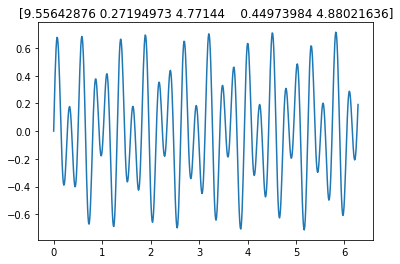

In [21]:
plt.plot(ts, X_train[1, :, 0])
plt.title(y_train[1])

In [22]:
from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, AveragePooling1D


model = Sequential()
model.add(Convolution1D(filters=64, kernel_size=2, input_shape=(n_ts, 1), padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Convolution1D(filters=32, kernel_size=2, padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Convolution1D(filters=16, kernel_size=2, padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Flatten())
model.add(Dropout(0.1)) # helps control overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_test.shape[1]))
model.add(Activation('linear'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 629, 64)           192       
_________________________________________________________________
activation_1 (Activation)    (None, 629, 64)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 314, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 314, 32)           4128      
_________________________________________________________________
activation_2 (Activation)    (None, 314, 32)           0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 157, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 157, 16)           1040      
__________

In [24]:
from keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(), metrics=['mae', 'mse'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=150, verbose=1)

Epoch 1/150


In [ ]:
pred = model.predict(X_test)

In [ ]:
ind = 2
plt.plot(ts, gen_timeseries(ts, pred[ind][0],  [(pred[ind][1],pred[ind][2]), (pred[ind][3],pred[ind][4])]), label="pred")
plt.plot(ts, gen_timeseries(ts, y_test[ind][0],  [(y_test[0][1],y_test[0][2]), (y_test[0][3],y_test[0][4])]), label="true")
plt.legend()

In [ ]:
plt.scatter(P_testing, pred[:,0], alpha=0.2)
plt.title("Period")
plt.xlabel("True period")
plt.ylabel("Predicted period")

In [ ]:
plt.scatter(y_test[:, 1], pred[:,1], alpha=0.2)
plt.title("Freq0 Amplitude")
plt.xlabel("True A")
plt.ylabel("Predicted A")

In [ ]:
plt.scatter(y_test[:, 2], pred[:,2], alpha=0.2)
plt.title("Freq0 Phase")
plt.xlabel("True Phase")
plt.ylabel("Predicted Phase")